# TIWs index from Meridional Velocity
## Tech preamble

In [1]:
%matplotlib inline
from pathlib import Path
import os
import time
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cmocean as co     # for details on this colormap module see https://matplotlib.org/cmocean/
import numpy as np
import xarray as xr
import dask
from dask.distributed import Client
from datetime import timedelta
from datetime import datetime
from scipy.signal import butter, filtfilt
from cycler import cycler
import matplotlib.colors as mcolors

## Dask-jobqueue and clients

In [2]:
# import dask_jobqueue
# cluster = dask_jobqueue.SLURMCluster(
#     # Dask worker size
#     cores=4, memory='24GB',
#     processes=1, # Dask workers per job
#     # SLURM job script things
#     queue='cluster', walltime='00:45:00',
#     # Dask worker network and temporary storage
#     interface='ib0', local_directory='$TMPDIR',
#     log_directory='./slurm_logs'
# )

In [3]:
# client = Client(cluster)
client = Client(n_workers=1, threads_per_worker=8, memory_limit=24e9)

/gxfs_work/geomar/smomw294/.conda/envs/INALT_wind_forcing/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41551 instead
  warnings.warn(


In [4]:
client

Client Scheduler: tcp://127.0.0.1:33283 Dashboard: http://127.0.0.1:41551/status,Cluster Workers: 1 Cores: 8 Memory: 24.00 GB


In [5]:
# cluster.adapt(
#     minimum=1, maximum=20,
# )

## Parameter preamble

In [6]:
script_name = "INALT20_meridional_Velocity_TIWs"
global_data_path = Path(f"../data/{script_name}")
JRA_path = "INALT20.L46-KFS10X"
JRA_exp_id = "INALT20.L46-KFS10?"

CORE_path = "shared/INALT20.L46-KFS044-S"
CORE_exp_id = "INALT20.L46-KFS044" # INALT COREv2

temp_res = "_5d_" # 5d:5-daily; 1m:monthly; 1y:yearly; 1d:daily(stored currently on TAPE) 
nest_prefix = "1_" # "1_" for high resolution; leave empty for base model

# chunk sizes
chu_x = 40 # None means take the full dataset
chu_y = 40
chu_z = 46
chu_t = None

# limits wanted
lat_lim1,lon_lim1 = [3,7],[-30,-10]
lat_lim2,lon_lim2 = [-7,-3],[-30,0]
lat_lon_str1 = f'{abs(lat_lim1[0])}n{abs(lat_lim1[1])}n_{abs(lon_lim1[0])}w{abs(lon_lim1[1])}w'
lat_lon_str2 = f'{abs(lat_lim2[0])}s{abs(lat_lim2[1])}s_{abs(lon_lim2[0])}w{abs(lon_lim2[1])}w'

lat_lon_title = [f'{abs(lat_lim1[0])}°N to {abs(lat_lim1[1])}°N, {abs(lon_lim1[0])}°W to {abs(lon_lim1[1])}°W',
                 f'{abs(lat_lim2[0])}°S to {abs(lat_lim2[1])}°S, {abs(lon_lim2[0])}°W to {abs(lon_lim2[1])}°']

grid1='vomecrty_3n7n_30w10w_grid_V'
grid2='vomecrty_3s7s_30w00w_grid_V'
zlim=150

## load YCM
EUC_data_path = Path("../data/INALT20_EUC_calc_transport/")
NEUC_data_path = Path("../data/INALT20_NEUC_calc_transport/")
SEUC_data_path = Path("../data/INALT20_SEUC_calc_transport/")
NECC_data_path = Path("../data/INALT20_NECC_calc_transport/")
nSECu_data_path = Path("../data/INALT20_nSECu_calc_transport/")

In [7]:
# Find aux data files
JRA_files = list(sorted(
(global_data_path ).glob(
    f"{nest_prefix}{JRA_exp_id}{temp_res}*{grid1}.nc")
))

CORE_files = list(sorted(
    (global_data_path).glob(
        f"{nest_prefix}{CORE_exp_id}{temp_res}*{grid1}.nc"
    )
))

aux_files = list(sorted(
    (global_data_path).glob(f"{nest_prefix}[m,n]*{grid1[9:-7]}.nc")
))

print(f"Found {len(aux_files)} mesh/mask files, {len(CORE_files)} CORE files, {len(JRA_files)} JRA files")

Found 1 mesh/mask files, 52 CORE files, 61 JRA files


In [8]:
out_dir_data = f"../data/{script_name}/"
Path(out_dir_data).mkdir(parents=True, exist_ok=True)

# out_fn_curl = f"INALT20_wind_curl_AH{temp_res}clim_{JRA_tlim[0]}_{JRA_tlim[1]}.nc"
# out_fn_taux = f"INALT20_wind_taux_AH{temp_res}clim_{JRA_tlim[0]}_{JRA_tlim[1]}.nc"

In [9]:
out_dir = f"../figures/{script_name}/"
Path(out_dir).mkdir(parents=True, exist_ok=True)
# fig_name_1 = f"INALT20_wind_curl_AH{temp_res}clim_{JRA_tlim[0]}_{JRA_tlim[1]}"
# fig_name_2 = f"INALT20_wind_curl_SAH{temp_res}clim_{JRA_tlim[0]}_{JRA_tlim[1]}"
# fig_name_3 = f"INALT20_wind_taux_AH{temp_res}clim_{JRA_tlim[0]}_{JRA_tlim[1]}"
# fig_format = ".png"
# savefig = 1

## Figure settings

In [10]:
font = {'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

# Functions

In [11]:
def getij_xyidx(ds_mesh,grid,latlim,lonlim):
    
    if grid=="T":
        lat,lon = ds_mesh.gphit.squeeze(),ds_mesh.glamt.squeeze()
    elif grid=="U":
        lat,lon = ds_mesh.gphiu.squeeze(),ds_mesh.glamu.squeeze()
    elif grid=="V":
        lat,lon = ds_mesh.gphiv.squeeze(),ds_mesh.glamv.squeeze()

    if grid=="T":
        cond = ((latlim[0]<=ds_mesh.gphit)&
                (ds_mesh.gphit<=latlim[1])&
                (lonlim[0]<=ds_mesh.glamt)&
                (ds_mesh.glamt<lonlim[1])
               )
    elif grid=="U":
        cond = ((latlim[0]<=ds_mesh.gphiu) & 
                       (ds_mesh.gphiu<=latlim[1]) &
                       (lonlim[0]<=ds_mesh.glamu) &
                       (ds_mesh.glamu<=lonlim[1]))
    elif grid=="V":
        cond = ((latlim[0]<=ds_mesh.gphiv) &
                       (ds_mesh.gphiv<=latlim[1]) &
                       (lonlim[0]<=ds_mesh.glamv) &
                       (ds_mesh.glamv<=lonlim[1]))
#     print(cond)
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        latidx = ds_mesh.where(cond,drop=True).y.load()
        lonidx = ds_mesh.where(cond,drop=True).x.load()
    return latidx,lonidx

In [12]:
def load_vomecrty(global_data_path,nest_prefix,JRA_exp_id,CORE_exp_id,temp_res,grid):
    JRA_files = list(sorted(
    (global_data_path ).glob(
        f"{nest_prefix}{JRA_exp_id}{temp_res}*{grid}.nc")
    ))

    CORE_files = list(sorted(
        (global_data_path).glob(
            f"{nest_prefix}{CORE_exp_id}{temp_res}*{grid}.nc"
        )
    ))
    
    aux_files = list(sorted(
    (global_data_path).glob(f"{nest_prefix}[m,n]*{grid[9:-7]}.nc")
    ))

    vars_drop = ['depthv_bounds','time_centered_bounds',
                 'time_counter_bounds','time_centered',
                 'nav_lat','nav_lon'] 

    with dask.config.set(scheduler='synchronous'):
        ds_mesh = xr.open_dataset(
                aux_files[0],
                decode_cf=True,
                chunks={"t":chu_t,"z":chu_z, 
                      "y":chu_y,"x":chu_x})
        ds_mesh.coords['y']=ds_mesh.y
        ds_mesh.coords['x']=ds_mesh.x
        ds_JRA = xr.open_mfdataset(
                JRA_files, #[idx1:idx2],
                decode_cf=True,
                chunks={"time_counter":chu_t,"depthv":chu_z, 
                      "y":chu_y,"x":chu_x}
            )

    ds_JRA = ds_JRA.assign_coords(lat=(['y','x'],ds_mesh.gphiv.squeeze().values))
    ds_JRA = ds_JRA.assign_coords(lon=(['y','x'],ds_mesh.glamv.squeeze().values))
    ds_JRA = ds_JRA.assign_coords(vmask=(['y','x'],ds_mesh.vmaskutil.squeeze().values))
    ds_JRA = ds_JRA.drop(vars_drop)
    
    with dask.config.set(scheduler='synchronous'):
        ds_CORE = xr.open_mfdataset(
            CORE_files, #[idx1:idx2],
            decode_cf=True,
            chunks={"time_counter":chu_t,"depthv":chu_z, 
                  "y":chu_y,"x":chu_x}
        )
    ds_CORE = ds_CORE.assign_coords(lat=(['y','x'],ds_mesh.gphiv.squeeze().values))
    ds_CORE = ds_CORE.assign_coords(lon=(['y','x'],ds_mesh.glamv.squeeze().values))
    ds_CORE = ds_CORE.assign_coords(vmask=(['y','x'],ds_mesh.vmaskutil.squeeze().values))
    # ds_CORE = ds_CORE.sel(depthv=zlim,method='nearest').sel(x=lonidx,y=latidx)
    ds_CORE = ds_CORE.drop(vars_drop)
    ds_CORE.coords['time_counter']=ds_JRA.time_counter.sel(
        time_counter=slice(None,'2009'))

    with xr.set_options(keep_attrs=True):
        ds = xr.concat([ds_JRA,ds_CORE],
                        'forcings')

    ds.coords['forcings'] = (['forcings'],['JRA','CORE'],)
    ds.coords['lon'] = (('x'),ds.lon.isel(y=8).values)
    ds.coords['lat'] = (('y'),ds.lat.isel(x=100).values)
    ds=ds.swap_dims({'x':'lon','y':'lat'})
    ds = ds.where(ds.vmask==1)
    return ds


In [13]:
def load_model_transports(data_path):
    JRA_exp_id = "INALT20.L46-KFS10?"
    CORE_exp_id = "INALT20.L46-KFS044" # INALT COREv2

    temp_res = "_5d_" # 5d:5-daily; 1m:monthly; 1y:yearly; 1d:daily(stored currently on TAPE) 
    nest_prefix = "1_" # "1_" for high resolution; leave empty for base model

    JRA_files = list(sorted(
        (data_path).glob(
            f"{nest_prefix}{JRA_exp_id}{temp_res}*transport.nc")
    ))

    CORE_files = list(sorted(
        (data_path ).glob(
            f"{nest_prefix}{CORE_exp_id}{temp_res}*transport.nc"
        )
    ))

    print(f"Found {len(CORE_files)} CORE files and {len(JRA_files)} JRA files.")
    
    ds_JRA = xr.open_mfdataset(
        JRA_files,
        combine='by_coords',
        decode_cf=True
    )
    
    ds_CORE = xr.open_mfdataset(
        CORE_files,
        combine='by_coords',
        decode_cf=True
    )
    ds_CORE.coords['time_counter']=ds_JRA.sel(time_counter=slice('1958','2009')).time_counter
    
    return ds_JRA, ds_CORE

In [14]:
# bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=1):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data,method='gust')
    return y

def lazy_butter_bp_filter(data, lowcut, highcut, fs,dim='time_counter'):
    y = xr.apply_ufunc(
        butter_bandpass_filter,
        data, lowcut, highcut, fs,
        input_core_dims=[[dim],[],[],[]],
        output_core_dims=[[dim]],
        dask='parallelized')
    return y

In [15]:
# # fitting with reductions
# def fit_vert_modes(pstruc,data,dz,dim='depth'):
#     return (pstruc*data*dz).sum(dim)

# def harmonic_cycle(t, T=1, phi=0):
#     """Create harmonic cycles."""
#     return np.sin(2 * np.pi / T * (t + phi))

# def normalize(x=None, y=None):
#     return y / np.linalg.norm(y) / (x.max() - x.min()) ** 0.5

# def harmonic_proj(t=None, T=None, dt=None, signal=None):
#     #     harmonic_mode = (
#     #         normalize(t, harmonic_cycle(t, T=T, phi=0))
#     #         + 1j * normalize(t, harmonic_cycle(t, T=T, phi=T / 4.0))
#     #     ) / (2 ** 0.5)
#     harmonic_mode = normalize(
#         t,
#         harmonic_cycle(t, T=T, phi=0) + 1j * harmonic_cycle(t, T=T, phi=T / 4.0)
#     )
#     return (signal * xr.DataArray(harmonic_mode, dims='time')* dt**0.5).sum('time')

# def harmonic_phase(t=None, T=None, dt=None, signal=None):
#     proj = harmonic_proj(t=t, T=T, dt=dt, signal=signal)
#     phi = np.arctan2(np.imag(proj), np.real(proj)) * T / np.pi / 2
#     phi.attrs['name'] = 'Phase'
#     phi.attrs['units'] = 'days'
#     return phi

# def harmonic_amplitude(t=None, T=None, dt=None, signal=None):
#     proj = harmonic_proj(t=t, T=T, dt=dt, signal=signal)
#     return 2 * np.abs(proj)

# def harm_fit(s_n):
#     time_ordinal = np.array([pd.to_datetime(x).toordinal() for x in s_n.time.values])
#     time_ordinal -= time_ordinal[0]
#     s_n.coords['time_ordinal']=(['time'],time_ordinal)
#     dt = time_ordinal[1]-time_ordinal[0]

#     ah_pha = harmonic_phase(s_n.time_ordinal, 365,dt, s_n)
#     ah_amp = harmonic_amplitude(s_n.time_ordinal, 365,dt, s_n)
#     sh_pha = harmonic_phase(time_ordinal, 365 / 2.0,dt, s_n)
#     sh_amp = harmonic_amplitude(time_ordinal, 365 / 2.0,dt, s_n)
#     return xr.merge((ah_pha.rename('ah_pha'), ah_amp.rename('ah_amp'), sh_pha.rename('sh_pha'), sh_amp.rename('sh_amp')))

# def reconstr_ts(harmo_JRA_obs,T):
#     t=np.arange(T)
#     t=xr.DataArray(data=t,dims='time')
#     if T==365:
#         amp,phi = harmo_JRA_obs.ah_amp,harmo_JRA_obs.ah_pha
#     elif T==365/2:
#         amp,phi = harmo_JRA_obs.sh_amp,harmo_JRA_obs.sh_pha
    
#     JRA_rec = amp * harmonic_cycle(
#         t, T=T, phi=phi)
#     JRA_rec.coords['time']=t
#     return JRA_rec

## Load model output

In [16]:
# EUC_JRA, EUC_CORE = load_model_transports(EUC_data_path)
NEUC_JRA, NEUC_CORE = load_model_transports(NEUC_data_path)
SEUC_JRA, SEUC_CORE = load_model_transports(SEUC_data_path)
# NECC_JRA, NECC_CORE = load_model_transports(NECC_data_path)
# nSECu_JRA, nSECu_CORE = load_model_transports(nSECu_data_path)

Found 52 CORE files and 61 JRA files.
Found 52 CORE files and 61 JRA files.


In [17]:
def call_bp_and_save(grid,global_data_path,nest_prefix,JRA_exp_id,CORE_exp_id,temp_res):
    ds = load_vomecrty(global_data_path,nest_prefix,JRA_exp_id,CORE_exp_id,temp_res,grid)

    # Temporal - Sample rate and desired cutoff frequencies (in 1/days).
    dt = 5 #time step of sampling
    fs = 1/dt # sample rate (1/day)
    lowcut = 1/50 # 1/50 days
    highcut = 1/20 # 1/20 days
    with xr.set_options(keep_attrs=True):
        v_bp = lazy_butter_bp_filter(
            ds.vomecrty.fillna(0).chunk({'time_counter':-1})*1e2, lowcut, highcut, fs,dim='time_counter'
            ) #.sel(time_counter=slice(f'{year-1}',f'{year+1}-01-31'))
        v_bp = v_bp.where(v_bp.vmask==1)

    # Zonally - Sample rate and desired cutoff frequencies (in 1/°).
    dx = 1/20 #lat step of sampling
    fs = 1/dx # sample rate (1/°)
    lowcut = 1/20 # 1/20°
    highcut = 1/4 # 1/4°

    with xr.set_options(keep_attrs=True):
        v_bp = lazy_butter_bp_filter(
               v_bp.fillna(0).chunk({'lon':-1}), lowcut, highcut, fs,dim='lon')
        v_bp = v_bp.where(v_bp.vmask==1)

    v_bp.attrs = ds.attrs

    v_bp.attrs['history'] = str(f'Temporally (20-50 days) and zonally (4°-20°) bandpass filtered meridional '+
                                f'velocity using a second order, zero-phase Butterworth filter, script: '+
                                f'{script_name}.ipynb'+
                                ', Previous history: ' + ds.attrs['history'])
    v_bp.lat.attrs['units']='°N'
    v_bp.lat.attrs['long_name']='Latitude'
    v_bp.lon.attrs['units']='°E'
    v_bp.lon.attrs['long_name']='Longitude'

    return v_bp

In [18]:
%%time
v_bp1 = call_bp_and_save(grid1,global_data_path,nest_prefix,JRA_exp_id,CORE_exp_id,temp_res)
dummy = v_bp1.isel(time_counter=-1)
dummy.coords['time_counter'] =  np.datetime64('2019-01-03T12:00:00.000000000')
v_bp1 = (xr.concat([v_bp1,dummy],'time_counter')).compute()

v_bp2 = call_bp_and_save(grid2,global_data_path,nest_prefix,JRA_exp_id,CORE_exp_id,temp_res)
dummy = v_bp2.isel(time_counter=-1)
dummy.coords['time_counter'] =  np.datetime64('2019-01-03T12:00:00.000000000')
v_bp2 = (xr.concat([v_bp2,dummy],'time_counter')).compute()

with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    v_bp1 = v_bp1.resample({'time_counter':'1D'},closed = 'right',label='right',loffset='-60H'
            ).nearest(tolerance='2D').sel(time_counter=slice(None,'2018'))
    v_bp2 = v_bp2.resample({'time_counter':'1D'},closed = 'right',label='right',loffset='-60H'
            ).nearest(tolerance='2D').sel(time_counter=slice(None,'2018'))

display(v_bp1)
display(v_bp2)

/gxfs_work/geomar/smomw294/.conda/envs/INALT_wind_forcing/lib/python3.8/site-packages/dask/array/core.py:3949: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/gxfs_work/geomar/smomw294/.conda/envs/INALT_wind_forcing/lib/python3.8/site-packages/dask/array/core.py:3949: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(


<xarray.DataArray 'vomecrty' (forcings: 2, depthv: 1, lat: 80, time_counter: 22280, lon: 401)>
array([[[[[-4.28376956e+00, -4.33690464e+00, -4.38102364e+00, ...,
           -2.64744994e-01, -2.35212408e-01, -2.14998844e-01],
          [-4.28376956e+00, -4.33690464e+00, -4.38102364e+00, ...,
           -2.64744994e-01, -2.35212408e-01, -2.14998844e-01],
          [-4.28376956e+00, -4.33690464e+00, -4.38102364e+00, ...,
           -2.64744994e-01, -2.35212408e-01, -2.14998844e-01],
          ...,
          [ 1.47252356e+00,  1.51723911e+00,  1.56897379e+00, ...,
           -1.12734694e+00, -1.10280436e+00, -1.08116596e+00],
          [ 1.47252356e+00,  1.51723911e+00,  1.56897379e+00, ...,
           -1.12734694e+00, -1.10280436e+00, -1.08116596e+00],
          [ 1.47252356e+00,  1.51723911e+00,  1.56897379e+00, ...,
           -1.12734694e+00, -1.10280436e+00, -1.08116596e+00]],

         [[-4.28929025e+00, -4.33321320e+00, -4.36670005e+00, ...,
           -6.96853468e-02, -4.53222405e-02, -3.01251695e-02],
          [-4.28929025e+00, -4.33321320e+00, -4.36670005e+00, ...,
           -6.96853468e-02, -4.53222405e-02, -3.01251695e-02],
          [-4.28929025e+00, -4.33321320e+00, -4.36670005e+00, ...,
           -6.96853468e-02, -4.53222405e-02, -3.01251695e-02],
...
          [ 1.11768953e-33,  1.26007080e-33,  1.41760780e-33, ...,
                       nan,             nan,             nan],
          [ 1.11768953e-33,  1.26007080e-33,  1.41760780e-33, ...,
                       nan,             nan,             nan],
          [ 1.11768953e-33,  1.26007080e-33,  1.41760780e-33, ...,
                       nan,             nan,             nan]],

         [[ 1.17098909e-01,  1.41663512e-01,  1.68457526e-01, ...,
                       nan,             nan,             nan],
          [ 1.17098909e-01,  1.41663512e-01,  1.68457526e-01, ...,
                       nan,             nan,             nan],
          [ 1.17098909e-01,  1.41663512e-01,  1.68457526e-01, ...,
                       nan,             nan,             nan],
          ...,
          [-1.09147349e-34, -2.33974722e-35,  7.69471890e-35, ...,
                       nan,             nan,             nan],
          [-1.09147349e-34, -2.33974722e-35,  7.69471890e-35, ...,
                       nan,             nan,             nan],
          [-1.09147349e-34, -2.33974722e-35,  7.69471890e-35, ...,
                       nan,             nan,             nan]]]]])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1958-01-01T12:00:00 ... 2018-...
  * depthv        (depthv) float32 160.3
  * lat           (lat) float32 3.024 3.074 3.123 3.173 ... 6.859 6.908 6.958
  * lon           (lon) float32 -30.0 -29.95 -29.9 -29.85 ... -10.1 -10.05 -10.0
    vmask         (lat, lon) int8 1 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0
  * forcings      (forcings) <U4 'JRA' 'CORE'
Attributes: (12/22)
    name:               1_INALT20.L46-KFS101_5d_19580101_19581231_grid_V
    description:        ocean V grid variables
    title:              ocean V grid variables
    Conventions:        CF-1.6
    timeStamp:          2019-Oct-07 04:23:14 GMT
    uuid:               cae87f27-28fb-4d8d-9516-978faf8441b5
    ...                 ...
    creator_name:       Kristin Burmeister
    creator_email:      kristin.burmeister@sams.ac.uk, ORCID 0000-0003-3881-0298
    license:            CC-BY4
    keywords:           Atlantic, ocean-model, high-resolution, temperature, ...
    reference:          Schwarzkopf et al., 2019, https://doi.org/10.5194/gmd...
    terms_of_use:       By using the given data the following terms and condi...

<xarray.DataArray 'vomecrty' (forcings: 2, depthv: 1, lat: 80, time_counter: 22280, lon: 601)>
array([[[[[ 1.05334871e+00,  1.04929128e+00,  1.04213827e+00, ...,
            2.25776738e-01,  2.27518177e-01,  2.32792888e-01],
          [ 1.05334871e+00,  1.04929128e+00,  1.04213827e+00, ...,
            2.25776738e-01,  2.27518177e-01,  2.32792888e-01],
          [ 1.05334871e+00,  1.04929128e+00,  1.04213827e+00, ...,
            2.25776738e-01,  2.27518177e-01,  2.32792888e-01],
          ...,
          [-8.73714557e-01, -8.25388666e-01, -7.75268952e-01, ...,
            6.88266970e-02,  8.29212854e-02,  9.71159532e-02],
          [-8.73714557e-01, -8.25388666e-01, -7.75268952e-01, ...,
            6.88266970e-02,  8.29212854e-02,  9.71159532e-02],
          [-8.73714557e-01, -8.25388666e-01, -7.75268952e-01, ...,
            6.88266970e-02,  8.29212854e-02,  9.71159532e-02]],

         [[ 9.98926033e-01,  9.92177114e-01,  9.82317229e-01, ...,
            2.13495442e-01,  2.18966603e-01,  2.27760214e-01],
          [ 9.98926033e-01,  9.92177114e-01,  9.82317229e-01, ...,
            2.13495442e-01,  2.18966603e-01,  2.27760214e-01],
          [ 9.98926033e-01,  9.92177114e-01,  9.82317229e-01, ...,
            2.13495442e-01,  2.18966603e-01,  2.27760214e-01],
...
          [-9.44319706e-33, -9.68121916e-33, -9.85155875e-33, ...,
            4.63874257e-33,  4.71199180e-33,  4.77454452e-33],
          [-9.44319706e-33, -9.68121916e-33, -9.85155875e-33, ...,
            4.63874257e-33,  4.71199180e-33,  4.77454452e-33],
          [-9.44319706e-33, -9.68121916e-33, -9.85155875e-33, ...,
            4.63874257e-33,  4.71199180e-33,  4.77454452e-33]],

         [[-2.29836600e+00, -2.34350758e+00, -2.36745370e+00, ...,
            7.73519692e-01,  7.83164462e-01,  8.01363938e-01],
          [-2.29836600e+00, -2.34350758e+00, -2.36745370e+00, ...,
            7.73519692e-01,  7.83164462e-01,  8.01363938e-01],
          [-2.29836600e+00, -2.34350758e+00, -2.36745370e+00, ...,
            7.73519692e-01,  7.83164462e-01,  8.01363938e-01],
          ...,
          [-2.96719346e-33, -2.81548341e-33, -2.60119547e-33, ...,
            4.52170127e-33,  4.76058502e-33,  5.01238323e-33],
          [-2.96719346e-33, -2.81548341e-33, -2.60119547e-33, ...,
            4.52170127e-33,  4.76058502e-33,  5.01238323e-33],
          [-2.96719346e-33, -2.81548341e-33, -2.60119547e-33, ...,
            4.52170127e-33,  4.76058502e-33,  5.01238323e-33]]]]])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1958-01-01T12:00:00 ... 2018-...
  * depthv        (depthv) float32 160.3
  * lat           (lat) float32 -6.958 -6.908 -6.859 ... -3.123 -3.074 -3.024
  * lon           (lon) float32 -30.0 -29.95 -29.9 ... -0.1 -0.05 -1.819e-12
    vmask         (lat, lon) int8 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
  * forcings      (forcings) <U4 'JRA' 'CORE'
Attributes: (12/22)
    name:               1_INALT20.L46-KFS101_5d_19580101_19581231_grid_V
    description:        ocean V grid variables
    title:              ocean V grid variables
    Conventions:        CF-1.6
    timeStamp:          2019-Oct-07 04:23:14 GMT
    uuid:               cae87f27-28fb-4d8d-9516-978faf8441b5
    ...                 ...
    creator_name:       Kristin Burmeister
    creator_email:      kristin.burmeister@sams.ac.uk, ORCID 0000-0003-3881-0298
    license:            CC-BY4
    keywords:           Atlantic, ocean-model, high-resolution, temperature, ...
    reference:          Schwarzkopf et al., 2019, https://doi.org/10.5194/gmd...
    terms_of_use:       By using the given data the following terms and condi...

CPU times: user 47.8 s, sys: 3min 26s, total: 4min 14s
Wall time: 5min 52s


In [19]:
# Calculate monthly standard deviation
# with dask.config.set(**{'array.slicing.split_large_chunks': True}):
#     v_bp1_std_mm = v_bp1.groupby("time_counter.month").std('time_counter')
#     v_bp2_std_mm = v_bp2.groupby("time_counter.month").std('time_counter')

In [20]:
v_bp1_std_mm = v_bp1.resample(time_counter='MS').std('time_counter')
v_bp2_std_mm = v_bp2.resample(time_counter='MS').std('time_counter')

/gxfs_work/geomar/smomw294/.conda/envs/INALT_wind_forcing/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/gxfs_work/geomar/smomw294/.conda/envs/INALT_wind_forcing/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/gxfs_work/geomar/smomw294/.conda/envs/INALT_wind_forcing/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/gxfs_work/geomar/smomw294/.conda/envs/INALT_wind_forcing/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/gxfs_work/geomar/smomw294/.conda/envs/INALT_wind_forcing/lib/python3.8/site

In [21]:
month_name = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
m_name = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
units = r'$cm\, s^{-1}$'
name = r'$\sigma(v^l)$'

In [22]:
f'{name} [{units}]'

'$\\sigma(v^l)$ [$cm\\, s^{-1}$]'

/gxfs_work/geomar/smomw294/.conda/envs/INALT_wind_forcing/lib/python3.8/site-packages/xarray/plot/plot.py:1451: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  and not np.issubdtype(x.dtype, str)
/gxfs_work/geomar/smomw294/.conda/envs/INALT_wind_forcing/lib/python3.8/site-packages/xarray/plot/plot.py:1466: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  and not np.issubdtype(y.dtype, str)


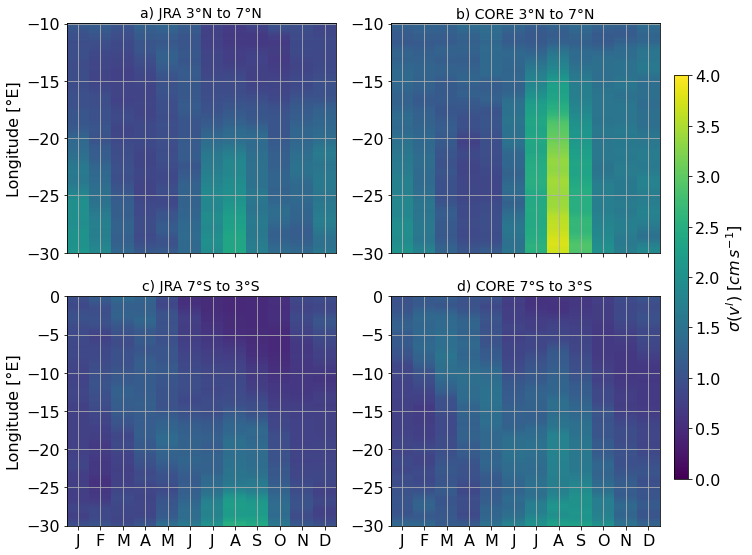

In [23]:
tlim=['1980','2009']
lat_lim1,lon_lim1 = [3,7],[-30,-10]
lat_lim2,lon_lim2 = [-7,-3],[-30,0]

lat_lon_title = [f'{abs(lat_lim1[0])}°N to {abs(lat_lim1[1])}°N',
                 f'{abs(lat_lim2[0])}°S to {abs(lat_lim2[1])}°S']
fig_tit = [f'a) JRA {lat_lon_title[0]}',
           f'b) CORE {lat_lon_title[0]}',
           f'c) JRA {lat_lon_title[1]}',
           f'd) CORE {lat_lon_title[1]}']

vstd_n = v_bp1_std_mm.sel(time_counter=slice(*tlim),lon=slice(*lon_lim1)).groupby('time_counter.month').mean('time_counter').mean(['lat']).squeeze()
vstd_s = v_bp2_std_mm.sel(time_counter=slice(*tlim),lon=slice(*lon_lim2)).groupby('time_counter.month').mean('time_counter').mean(['lat']).squeeze()

vstd_n.attrs = dict(long_name=name, units=units, month_name=month_name)
vstd_s.attrs = dict(long_name=name, units=units, month_name=month_name)

fig,axs = plt.subplots(2,2,sharex=True,figsize=[10,8])
# axs[0].set_prop_cycle(cycler(color=mcolors.to_rgba_array(['C1', 'C0'])))
# axs[1].set_prop_cycle(cycler(color=mcolors.to_rgba_array(['C1', 'C0'])))
im = vstd_n.sel(forcings='JRA').plot(x='month',ax=axs[0,0],vmin=0,vmax=4,add_colorbar=False)
vstd_n.sel(forcings='CORE').plot(x='month',ax=axs[0,1],vmin=0,vmax=4,add_colorbar=False)
vstd_s.sel(forcings='JRA').plot(x='month',ax=axs[1,0],vmin=0,vmax=4,add_colorbar=False)
vstd_s.sel(forcings='CORE').plot(x='month',ax=axs[1,1],vmin=0,vmax=4,add_colorbar=False)
for idx,ax in enumerate(axs.flat):
    ax.grid()
    ax.set_xlabel('')
    ax.set_xticks(vstd_n.month)
    ax.set_xticklabels(m_name)
    ax.set_title(fig_tit[idx],fontsize = 14)
axs[0,1].set_ylabel('')
axs[1,1].set_ylabel('')
plt.tight_layout()

fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb =fig.colorbar(im, cax=cbar_ax)
cb.set_label(f'{name} [{units}]')

fig.savefig((Path(out_dir)/f'INALT20_HM_JRA_CORE_TIW_NEUC_SEUC_clim_{tlim[0]}_{tlim[1]}'),dpi=300,bbox_inches='tight')

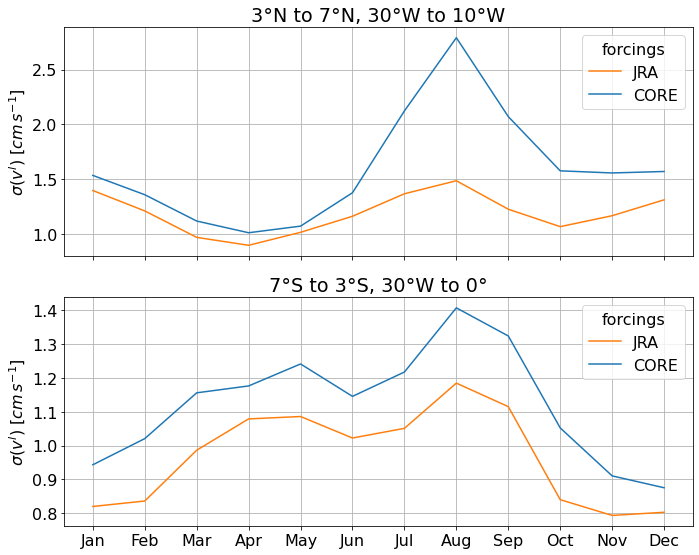

In [24]:
tlim=['1980','2009']
lat_lim1,lon_lim1 = [3,7],[-30,-10]
lat_lim2,lon_lim2 = [-7,-3],[-30,0]

lat_lon_title = [f'{abs(lat_lim1[0])}°N to {abs(lat_lim1[1])}°N, {abs(lon_lim1[0])}°W to {abs(lon_lim1[1])}°W',
                 f'{abs(lat_lim2[0])}°S to {abs(lat_lim2[1])}°S, {abs(lon_lim2[0])}°W to {abs(lon_lim2[1])}°']

vstd_n = v_bp1_std_mm.sel(time_counter=slice(*tlim),lon=slice(*lon_lim1)).groupby('time_counter.month').mean('time_counter').mean(['lon','lat']).squeeze()
vstd_s = v_bp2_std_mm.sel(time_counter=slice(*tlim),lon=slice(*lon_lim2)).groupby('time_counter.month').mean('time_counter').mean(['lon','lat']).squeeze()

vstd_n.attrs = dict(long_name=name, units=units, month_name=month_name)
vstd_s.attrs = dict(long_name=name, units=units, month_name=month_name)

fig,axs = plt.subplots(2,1,sharex=True,figsize=[10,8])
axs[0].set_prop_cycle(cycler(color=mcolors.to_rgba_array(['C1', 'C0'])))
axs[1].set_prop_cycle(cycler(color=mcolors.to_rgba_array(['C1', 'C0'])))
vstd_n.plot(ax=axs[0],hue='forcings')
vstd_s.plot(ax=axs[1],hue='forcings')
for idx,ax in enumerate(axs):
    ax.grid()
    ax.set_xlabel('')
    ax.set_xticks(vstd_n.month)
    ax.set_xticklabels(month_name)
    ax.set_title(lat_lon_title[idx])
plt.tight_layout()
fig.savefig((Path(out_dir)/f'INALT20_JRA_CORE_TIW_NEUC_SEUC_clim_{tlim[0]}_{tlim[1]}'))

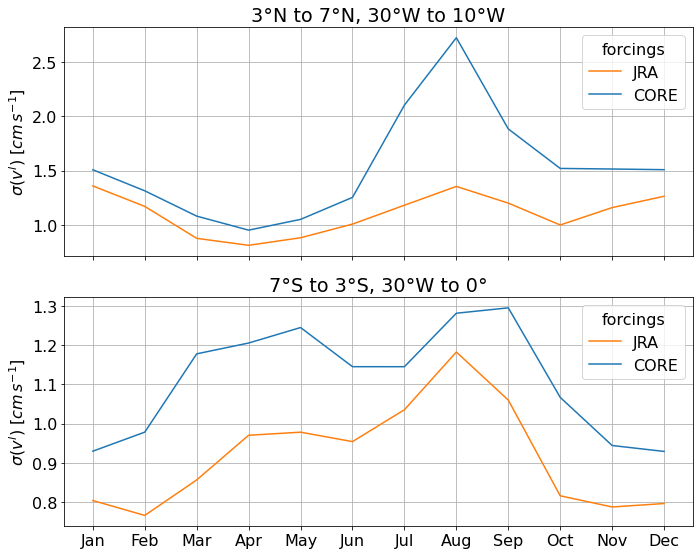

In [25]:
tlim=['1991','2009']
lat_lim1,lon_lim1 = [3,7],[-30,-10]
lat_lim2,lon_lim2 = [-7,-3],[-30,0]

lat_lon_title = [f'{abs(lat_lim1[0])}°N to {abs(lat_lim1[1])}°N, {abs(lon_lim1[0])}°W to {abs(lon_lim1[1])}°W',
                 f'{abs(lat_lim2[0])}°S to {abs(lat_lim2[1])}°S, {abs(lon_lim2[0])}°W to {abs(lon_lim2[1])}°']

vstd_n = v_bp1_std_mm.sel(time_counter=slice(*tlim),lon=slice(*lon_lim1)).groupby('time_counter.month').mean('time_counter').mean(['lon','lat']).squeeze()
vstd_s = v_bp2_std_mm.sel(time_counter=slice(*tlim),lon=slice(*lon_lim2)).groupby('time_counter.month').mean('time_counter').mean(['lon','lat']).squeeze()

vstd_n.attrs = dict(long_name=name, units=units, month_name=month_name)
vstd_s.attrs = dict(long_name=name, units=units, month_name=month_name)

fig,axs = plt.subplots(2,1,sharex=True,figsize=[10,8])
axs[0].set_prop_cycle(cycler(color=mcolors.to_rgba_array(['C1', 'C0'])))
axs[1].set_prop_cycle(cycler(color=mcolors.to_rgba_array(['C1', 'C0'])))
vstd_n.plot(ax=axs[0],hue='forcings')
vstd_s.plot(ax=axs[1],hue='forcings')
for idx,ax in enumerate(axs):
    ax.grid()
    ax.set_xlabel('')
    ax.set_xticks(vstd_n.month)
    ax.set_xticklabels(month_name)
    ax.set_title(lat_lon_title[idx])
plt.tight_layout()
fig.savefig((Path(out_dir)/f'INALT20_JRA_CORE_TIW_NEUC_SEUC_clim_{tlim[0]}_{tlim[1]}'))

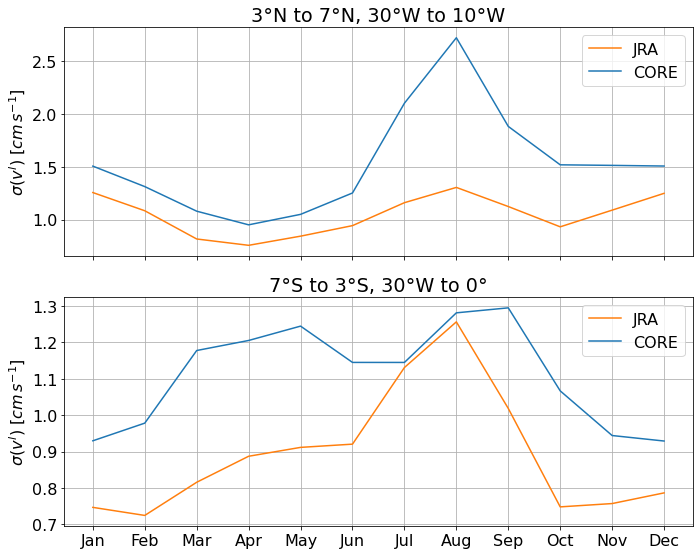

In [26]:
tlim_JRA=['2000','2018']
tlim_CORE=['1991','2009']
lat_lim1,lon_lim1 = [3,7],[-30,-10]
lat_lim2,lon_lim2 = [-7,-3],[-30,0]

lat_lon_title = [f'{abs(lat_lim1[0])}°N to {abs(lat_lim1[1])}°N, {abs(lon_lim1[0])}°W to {abs(lon_lim1[1])}°W',
                 f'{abs(lat_lim2[0])}°S to {abs(lat_lim2[1])}°S, {abs(lon_lim2[0])}°W to {abs(lon_lim2[1])}°']

vstd_n_JRA = v_bp1_std_mm.sel(time_counter=slice(*tlim_JRA),forcings='JRA',lon=slice(*lon_lim1)).groupby('time_counter.month').mean('time_counter').mean(['lon','lat']).squeeze()
vstd_s_JRA = v_bp2_std_mm.sel(time_counter=slice(*tlim_JRA),forcings='JRA',lon=slice(*lon_lim2)).groupby('time_counter.month').mean('time_counter').mean(['lon','lat']).squeeze()
vstd_n_CORE = v_bp1_std_mm.sel(time_counter=slice(*tlim_CORE),forcings='CORE',lon=slice(*lon_lim1)).groupby('time_counter.month').mean('time_counter').mean(['lon','lat']).squeeze()
vstd_s_CORE = v_bp2_std_mm.sel(time_counter=slice(*tlim_CORE),forcings='CORE',lon=slice(*lon_lim2)).groupby('time_counter.month').mean('time_counter').mean(['lon','lat']).squeeze()

vstd_n_JRA.attrs = dict(long_name=name, units=units, month_name=month_name)
vstd_s_JRA.attrs = dict(long_name=name, units=units, month_name=month_name)
vstd_n_CORE.attrs = dict(long_name=name, units=units, month_name=month_name)
vstd_s_CORE.attrs = dict(long_name=name, units=units, month_name=month_name)

fig,axs = plt.subplots(2,1,sharex=True,figsize=[10,8])
axs[0].set_prop_cycle(cycler(color=mcolors.to_rgba_array(['C1', 'C0'])))
axs[1].set_prop_cycle(cycler(color=mcolors.to_rgba_array(['C1', 'C0'])))
vstd_n_JRA.plot(ax=axs[0],label='JRA')
vstd_n_CORE.plot(ax=axs[0],label='CORE')
vstd_s_JRA.plot(ax=axs[1],label='JRA')
vstd_s_CORE.plot(ax=axs[1],label='CORE')
for idx,ax in enumerate(axs):
    ax.grid()
    ax.set_xlabel('')
    ax.set_xticks(vstd_n.month)
    ax.set_xticklabels(month_name)
    ax.set_title(lat_lon_title[idx])
    ax.legend()
plt.tight_layout()
fig.savefig((Path(out_dir)/f'INALT20_JRA_CORE_TIW_NEUC_SEUC_climJ_{tlim_JRA[0]}_{tlim_JRA[1]}_climC_{tlim_CORE[0]}_{tlim_CORE[1]}'))

In [27]:
# v_bp1_std_mm = v_bp1.resample(time_counter='MS').std('time_counter')
# v_bp2_std_mm = v_bp2.resample(time_counter='MS').std('time_counter')
NEUC_JRA_mm = NEUC_JRA.resample(time_counter='MS').mean('time_counter').compute()
NEUC_CORE_mm = NEUC_CORE.resample(time_counter='MS').mean('time_counter').compute()
SEUC_JRA_mm = SEUC_JRA.resample(time_counter='MS').mean('time_counter').compute()
SEUC_CORE_mm = SEUC_CORE.resample(time_counter='MS').mean('time_counter').compute()

In [28]:
NEUC_TIW_mm = v_bp1_std_mm.mean(['lat','lon']).squeeze()
SEUC_TIW_mm = v_bp2_std_mm.mean(['lat','lon']).squeeze()
SEUC_TIW_mm

<xarray.DataArray 'vomecrty' (forcings: 2, time_counter: 732)>
array([[8.58756948e-01, 9.06362211e-01, 9.89882222e-01, ...,
        7.81531959e-01, 5.66899537e-01, 8.91643246e-01],
       [8.78935043e-01, 9.28881224e-01, 1.04740047e+00, ...,
        4.29549032e-36, 1.07357949e-34, 2.11844021e-33]])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1958-01-01 ... 2018-12-01
    depthv        float32 160.3
  * forcings      (forcings) <U4 'JRA' 'CORE'

In [29]:
INT_units = r'$Sv$'
INT_name = r'INT'

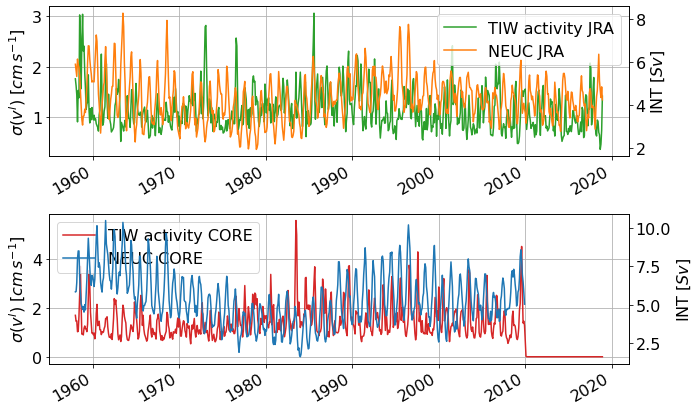

In [30]:
tlim=['1958','2018']
vstd_n_JRA = NEUC_TIW_mm.sel(forcings='JRA',time_counter=slice(*tlim))
NEUC_INT_JRA = NEUC_JRA_mm.INT.sel(time_counter=slice(*tlim)).mean('lon')
vstd_n_CORE = NEUC_TIW_mm.sel(forcings='CORE',time_counter=slice(*tlim))
NEUC_INT_CORE = NEUC_CORE_mm.INT.sel(time_counter=slice(*tlim)).mean('lon')

vstd_n_JRA.attrs = dict(long_name=name, units=units)
NEUC_INT_JRA.attrs = dict(long_name=INT_name, units=INT_units)
vstd_n_CORE.attrs = dict(long_name=name, units=units)
NEUC_INT_CORE.attrs = dict(long_name=INT_name, units=INT_units)

fig, axs = plt.subplots(2,1,figsize = [10,6])
add_ax = axs[0].twinx()
lns1 = vstd_n_JRA.plot(ax=axs[0],label='TIW activity JRA',color='C2')
lns2 = NEUC_INT_JRA.plot(ax=add_ax,label='NEUC JRA',color='C1')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
axs[0].legend(lns, labs)

add_ax = axs[1].twinx()
lns1 = vstd_n_CORE.plot(ax=axs[1],label='TIW activity CORE',color='C3')
lns2 = NEUC_INT_CORE.plot(ax=add_ax,label='NEUC CORE',color='C0')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
axs[1].legend(lns, labs,loc=2)

for idx,ax in enumerate(axs):
    ax.grid()
    ax.set_xlabel('')
    ax.set_title('')
plt.tight_layout()


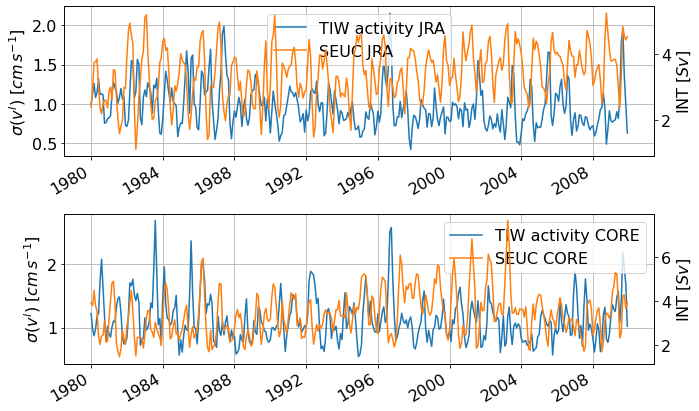

In [31]:
tlim=['1980','2009']
vstd_n_JRA = SEUC_TIW_mm.sel(forcings='JRA',time_counter=slice(*tlim))
SEUC_INT_JRA = SEUC_JRA_mm.INT.sel(time_counter=slice(*tlim)).mean('lon')
vstd_n_CORE = SEUC_TIW_mm.sel(forcings='CORE',time_counter=slice(*tlim))
SEUC_INT_CORE = SEUC_CORE_mm.INT.sel(time_counter=slice(*tlim)).mean('lon')

vstd_n_JRA.attrs = dict(long_name=name, units=units)
SEUC_INT_JRA.attrs = dict(long_name=INT_name, units=INT_units)
vstd_n_CORE.attrs = dict(long_name=name, units=units)
SEUC_INT_CORE.attrs = dict(long_name=INT_name, units=INT_units)

fig, axs = plt.subplots(2,1,figsize = [10,6])
add_ax = axs[0].twinx()
lns1 = vstd_n_JRA.plot(ax=axs[0],label='TIW activity JRA')
lns2 = SEUC_INT_JRA.plot(ax=add_ax,label='SEUC JRA',color='C1')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
axs[0].legend(lns, labs)

add_ax = axs[1].twinx()
lns1 = vstd_n_CORE.plot(ax=axs[1],label='TIW activity CORE')
lns2 = SEUC_INT_CORE.plot(ax=add_ax,label='SEUC CORE',color='C1')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
axs[1].legend(lns, labs)

for idx,ax in enumerate(axs):
    ax.grid()
    ax.set_xlabel('')
    ax.set_title('')
plt.tight_layout()


/gxfs_work/geomar/smomw294/.conda/envs/INALT_wind_forcing/lib/python3.8/site-packages/xarray/plot/plot.py:1451: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  and not np.issubdtype(x.dtype, str)
/gxfs_work/geomar/smomw294/.conda/envs/INALT_wind_forcing/lib/python3.8/site-packages/xarray/plot/plot.py:1466: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  and not np.issubdtype(y.dtype, str)


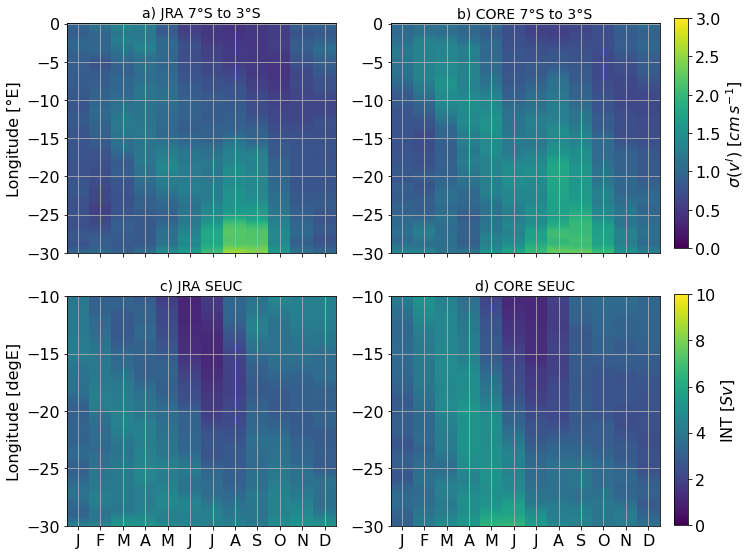

In [32]:
tlim=['1980','2009']
lat_lim1,lon_lim1 = [3,7],[-30,-18]
lat_lim2,lon_lim2 = [-7,-3],[-30,0]

lat_lon_title = [f'{abs(lat_lim1[0])}°N to {abs(lat_lim1[1])}°N',
                 f'{abs(lat_lim2[0])}°S to {abs(lat_lim2[1])}°S']
fig_tit = [f'a) JRA {lat_lon_title[1]}',
           f'b) CORE {lat_lon_title[1]}',
           f'c) JRA SEUC',
           f'd) CORE SEUC']

vstd_n = v_bp1_std_mm.sel(time_counter=slice(*tlim),lon=slice(*lon_lim1)).groupby('time_counter.month').mean('time_counter').mean(['lat']).squeeze()
vstd_s = v_bp2_std_mm.sel(time_counter=slice(*tlim),lon=slice(*lon_lim2)).groupby('time_counter.month').mean('time_counter').mean(['lat']).squeeze()
SEUC_INT_JRA = SEUC_JRA_mm.INT.sel(time_counter=slice(*tlim),lon=slice(*lon_lim2)).groupby('time_counter.month').mean('time_counter').squeeze()
SEUC_INT_CORE = SEUC_CORE_mm.INT.sel(time_counter=slice(*tlim),lon=slice(*lon_lim2)).groupby('time_counter.month').mean('time_counter').squeeze()

vstd_n.attrs = dict(long_name=name, units=units, month_name=month_name)
vstd_s.attrs = dict(long_name=name, units=units, month_name=month_name)
SEUC_INT_JRA.attrs = dict(long_name=INT_name, units=INT_units)
SEUC_INT_CORE.attrs = dict(long_name=INT_name, units=INT_units)

fig,axs = plt.subplots(2,2,sharex=True,figsize=[10,8])
im = vstd_s.sel(forcings='JRA').plot(x='month',ax=axs[0,0],vmin=0,vmax=3,add_colorbar=False)
vstd_s.sel(forcings='CORE').plot(x='month',ax=axs[0,1],vmin=0,vmax=3,add_colorbar=False)
im2 = SEUC_INT_JRA.plot(x='month',ax=axs[1,0],vmin=0,vmax=10,add_colorbar=False)
SEUC_INT_CORE.plot(x='month',ax=axs[1,1],vmin=0,vmax=10,add_colorbar=False)
for idx,ax in enumerate(axs.flat):
    ax.grid()
    ax.set_xlabel('')
    ax.set_xticks(vstd_n.month)
    ax.set_xticklabels(m_name)
    ax.set_title(fig_tit[idx],fontsize = 14)
axs[0,1].set_ylabel('')
axs[1,1].set_ylabel('')
plt.tight_layout()

fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.55, 0.02, 0.4])
cb =fig.colorbar(im, cax=cbar_ax)
cb.set_label(f'{name} [{units}]')
cbar_ax2 = fig.add_axes([0.95, 0.07, 0.02, 0.4])
cb2 =fig.colorbar(im2, cax=cbar_ax2)
cb2.set_label(f'{INT_name} [{INT_units}]')


# fig.savefig((Path(out_dir)/f'INALT20_HM_JRA_CORE_TIW_NEUC_SEUC_clim_{tlim[0]}_{tlim[1]}'),dpi=300,bbox_inches='tight')

/gxfs_work/geomar/smomw294/.conda/envs/INALT_wind_forcing/lib/python3.8/site-packages/xarray/plot/plot.py:1451: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  and not np.issubdtype(x.dtype, str)
/gxfs_work/geomar/smomw294/.conda/envs/INALT_wind_forcing/lib/python3.8/site-packages/xarray/plot/plot.py:1466: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  and not np.issubdtype(y.dtype, str)


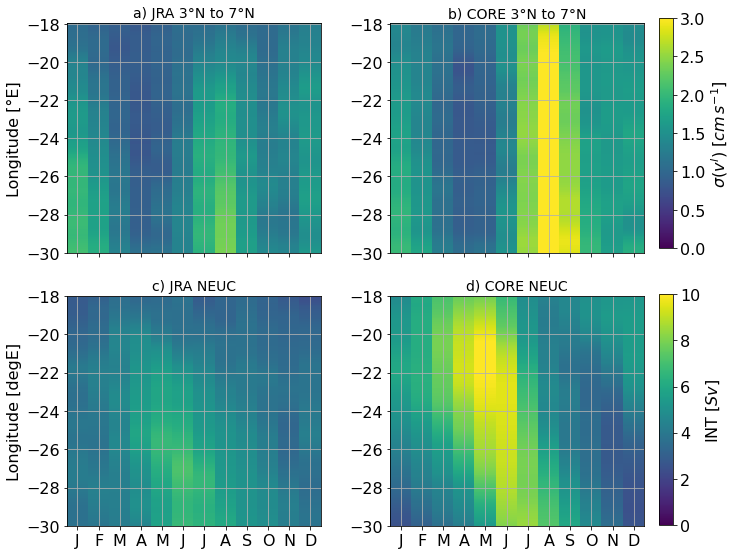

In [33]:
tlim=['1980','2009']
lat_lim1,lon_lim1 = [3,7],[-30,-18]
lat_lim2,lon_lim2 = [-7,-3],[-30,0]

lat_lon_title = [f'{abs(lat_lim1[0])}°N to {abs(lat_lim1[1])}°N',
                 f'{abs(lat_lim2[0])}°S to {abs(lat_lim2[1])}°S']
fig_tit = [f'a) JRA {lat_lon_title[0]}',
           f'b) CORE {lat_lon_title[0]}',
           f'c) JRA NEUC',
           f'd) CORE NEUC']

vstd_n = v_bp1_std_mm.sel(time_counter=slice(*tlim),lon=slice(*lon_lim1)).groupby('time_counter.month').mean('time_counter').mean(['lat']).squeeze()
vstd_s = v_bp2_std_mm.sel(time_counter=slice(*tlim),lon=slice(*lon_lim2)).groupby('time_counter.month').mean('time_counter').mean(['lat']).squeeze()
NEUC_INT_JRA = NEUC_JRA_mm.INT.sel(time_counter=slice(*tlim),lon=slice(*lon_lim1)).groupby('time_counter.month').mean('time_counter').squeeze()
NEUC_INT_CORE = NEUC_CORE_mm.INT.sel(time_counter=slice(*tlim),lon=slice(*lon_lim1)).groupby('time_counter.month').mean('time_counter').squeeze()

vstd_n.attrs = dict(long_name=name, units=units, month_name=month_name)
vstd_s.attrs = dict(long_name=name, units=units, month_name=month_name)
NEUC_INT_JRA.attrs = dict(long_name=INT_name, units=INT_units)
NEUC_INT_CORE.attrs = dict(long_name=INT_name, units=INT_units)

fig,axs = plt.subplots(2,2,sharex=True,figsize=[10,8])
# axs[0].set_prop_cycle(cycler(color=mcolors.to_rgba_array(['C1', 'C0'])))
# axs[1].set_prop_cycle(cycler(color=mcolors.to_rgba_array(['C1', 'C0'])))
im = vstd_n.sel(forcings='JRA').plot(x='month',ax=axs[0,0],vmin=0,vmax=3,add_colorbar=False)
vstd_n.sel(forcings='CORE').plot(x='month',ax=axs[0,1],vmin=0,vmax=3,add_colorbar=False)
# vstd_s.sel(forcings='JRA').plot(x='month',ax=axs[1,0],vmin=0,vmax=0.04,add_colorbar=False)
# vstd_s.sel(forcings='CORE').plot(x='month',ax=axs[1,1],vmin=0,vmax=0.04,add_colorbar=False)
im2 = NEUC_INT_JRA.plot(x='month',ax=axs[1,0],vmin=0,vmax=10,add_colorbar=False)
NEUC_INT_CORE.plot(x='month',ax=axs[1,1],vmin=0,vmax=10,add_colorbar=False)
for idx,ax in enumerate(axs.flat):
    ax.grid()
    ax.set_xlabel('')
    ax.set_xticks(vstd_n.month)
    ax.set_xticklabels(m_name)
    ax.set_title(fig_tit[idx],fontsize = 14)
axs[0,1].set_ylabel('')
axs[1,1].set_ylabel('')
plt.tight_layout()

fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.55, 0.02, 0.4])
cb =fig.colorbar(im, cax=cbar_ax)
cb.set_label(f'{name} [{units}]')
cbar_ax2 = fig.add_axes([0.95, 0.07, 0.02, 0.4])
cb2 =fig.colorbar(im2, cax=cbar_ax2)
cb2.set_label(f'{INT_name} [{INT_units}]')

# Annual Mean

In [34]:
tlim_min_J,tlim_max_J = '1980','2009' #'2000','2018'
tlim_min_C,tlim_max_C = '1980','2009' #'1991','2019'
NEUC_JRA_cyc = NEUC_JRA.sel(time_counter=slice(tlim_min_J,tlim_max_J)).groupby(
        'time_counter.dayofyear').mean(dim='time_counter').compute()
NEUC_CORE_cyc = NEUC_CORE.sel(time_counter=slice(tlim_min_C,tlim_max_C)).groupby(
    'time_counter.dayofyear').mean(dim='time_counter').compute()
SEUC_JRA_cyc = SEUC_JRA.sel(time_counter=slice(tlim_min_J,tlim_max_J)).groupby(
        'time_counter.dayofyear').mean(dim='time_counter').compute()
SEUC_CORE_cyc = SEUC_CORE.sel(time_counter=slice(tlim_min_C,tlim_max_C)).groupby(
    'time_counter.dayofyear').mean(dim='time_counter').compute()

In [35]:
NEUC_JRA_A = NEUC_JRA.groupby('time_counter.dayofyear') - NEUC_JRA_cyc
SEUC_JRA_A = SEUC_JRA.groupby('time_counter.dayofyear') - SEUC_JRA_cyc
NEUC_CORE_A = NEUC_CORE.groupby('time_counter.dayofyear') - NEUC_CORE_cyc
SEUC_CORE_A = SEUC_CORE.groupby('time_counter.dayofyear') - SEUC_CORE_cyc

In [36]:
NEUC_JRA_am = NEUC_JRA_A.resample(time_counter='1Y').mean('time_counter').compute()
NEUC_CORE_am = NEUC_CORE_A.resample(time_counter='1Y').mean('time_counter').compute()
SEUC_JRA_am = SEUC_JRA_A.resample(time_counter='1Y').mean('time_counter').compute()
SEUC_CORE_am = SEUC_CORE_A.resample(time_counter='1Y').mean('time_counter').compute()

distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [37]:
def is_amj(month):
    return (month >= 5) & (month <= 7)

NEUC_TIW_mm_mjj = NEUC_TIW_mm.sel(time_counter=is_amj(NEUC_TIW_mm['time_counter.month']))
SEUC_TIW_mm_mjj = SEUC_TIW_mm.sel(time_counter=is_amj(SEUC_TIW_mm['time_counter.month']))

In [38]:
NEUC_TIW_mm_mjj = NEUC_TIW_mm_mjj.resample(time_counter='1Y').mean('time_counter')
SEUC_TIW_mm_mjj = SEUC_TIW_mm_mjj.resample(time_counter='1Y').mean('time_counter')

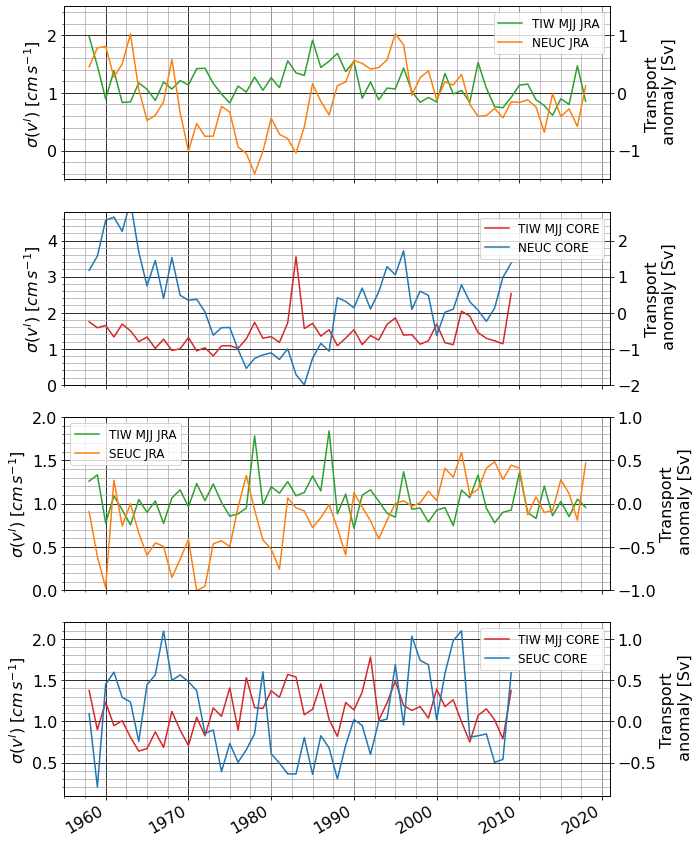

In [39]:
tlim=['1958','2018']
vstd_n_JRA = NEUC_TIW_mm_mjj.sel(forcings='JRA',time_counter=slice(*tlim))
NEUC_INT_JRA = NEUC_JRA_am.INT.sel(time_counter=slice(*tlim)).mean('lon')
vstd_n_CORE = NEUC_TIW_mm_mjj.sel(forcings='CORE',time_counter=slice(None,'2009'))
NEUC_INT_CORE = NEUC_CORE_am.INT.sel(time_counter=slice(*tlim)).mean('lon')

vstd_n_JRA.attrs = dict(long_name=name, units=units)
NEUC_INT_JRA.attrs = dict(long_name=INT_name, units=INT_units)
vstd_n_CORE.attrs = dict(long_name=name, units=units)
NEUC_INT_CORE.attrs = dict(long_name=INT_name, units=INT_units)

fig, axs = plt.subplots(4,1,figsize = [10,12],sharex=True)

lns1 = vstd_n_JRA.plot(ax=axs[0],label='TIW MJJ JRA',color='C2')

add_ax = axs[0].twinx()
lns2 = NEUC_INT_JRA.plot(ax=add_ax,label='NEUC JRA',color='C1')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
axs[0].legend(lns, labs,loc=1,prop={'size': 12})
add_ax.set_ylim([-1.5,1.5])
add_ax.set_ylabel('Transport\n anomaly [Sv]')

lns1 = vstd_n_CORE.plot(ax=axs[1],label='TIW MJJ CORE',color='C3')
add_ax = axs[1].twinx()
lns2 = NEUC_INT_CORE.plot(ax=add_ax,label='NEUC CORE',color='C0')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
axs[1].legend(lns, labs,loc=1,prop={'size': 12})
add_ax.set_ylim([-2,2.8])
add_ax.set_ylabel('Transport\n anomaly [Sv]')


vstd_n_JRA = SEUC_TIW_mm_mjj.sel(forcings='JRA',time_counter=slice(*tlim))
SEUC_INT_JRA = SEUC_JRA_am.INT.sel(time_counter=slice(*tlim)).mean('lon')
vstd_n_CORE = SEUC_TIW_mm_mjj.sel(forcings='CORE',time_counter=slice(None,'2009'))
SEUC_INT_CORE = SEUC_CORE_am.INT.sel(time_counter=slice(*tlim)).mean('lon')

vstd_n_JRA.attrs = dict(long_name=name, units=units)
SEUC_INT_JRA.attrs = dict(long_name=INT_name, units=INT_units)
vstd_n_CORE.attrs = dict(long_name=name, units=units)
SEUC_INT_CORE.attrs = dict(long_name=INT_name, units=INT_units)

lns1 = vstd_n_JRA.plot(ax=axs[2],label='TIW MJJ JRA',color='C2')
add_ax = axs[2].twinx()
lns2 = SEUC_INT_JRA.plot(ax=add_ax,label='SEUC JRA',color='C1')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
axs[2].legend(lns, labs,loc=2,prop={'size': 12})
add_ax.set_ylim([-1.,1])
add_ax.set_ylabel('Transport\n anomaly [Sv]')

lns1 = vstd_n_CORE.plot(ax=axs[3],label='TIW MJJ CORE',color='C3')
add_ax = axs[3].twinx()
lns2 = SEUC_INT_CORE.plot(ax=add_ax,label='SEUC CORE',color='C0')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
axs[3].legend(lns, labs,prop={'size': 12})
add_ax.set_ylim([-0.9,1.2])
add_ax.set_ylabel('Transport\n anomaly [Sv]')

for idx,ax in enumerate(axs):
    ax.set_xlabel('')
    ax.set_title('')
    ax.grid(which='major',color='k')
    ax.grid(which='minor')
    ax.minorticks_on()
    ax.set_xticks(['1961-01-01','1971-01-01','1981-01-01','1991-01-01','2001-01-01','2011-01-01','2021-01-01'])
    ax.set_xticklabels(['1960','1970','1980','1990','2000','2010','2020'])

axs[0].set_ylim([-0.5,2.5])
axs[1].set_ylim([0,4.8])
axs[2].set_ylim([0,2])
axs[3].set_ylim([0.1,2.2])

plt.tight_layout()
fig.savefig((Path(out_dir)/f'INALT20_JRA_CORE_TIW_NEUC_SEUC_MJJ_ts.png'),dpi=300,bbox_inches='tight')

max correlation 0.2881667434421491 is at lag -10


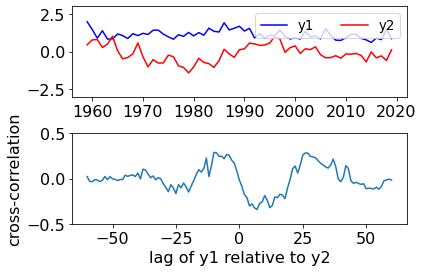

In [40]:
vstd_n_JRA = NEUC_TIW_mm_mjj.sel(forcings='JRA',time_counter=slice(*tlim))
NEUC_INT_JRA = NEUC_JRA_am.INT.sel(time_counter=slice(*tlim)).mean('lon')
vstd_n_CORE = NEUC_TIW_mm_mjj.sel(forcings='CORE',time_counter=slice(None,'2009'))
NEUC_INT_CORE = NEUC_CORE_am.INT.sel(time_counter=slice(None,'2009')).mean('lon')

y1=vstd_n_JRA.values
y2=NEUC_INT_JRA.values
npts = len(vstd_n_JRA)
lags = np.arange(-npts + 1, npts)
ccov = np.correlate(y1 - y1.mean(), y2 - y2.mean(), mode='full')
ccor = ccov / (npts * y1.std() * y2.std())

fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=0.4)
ax = axs[0]
ax.plot(vstd_n_JRA.time_counter, y1, 'b', label='y1')
ax.plot(NEUC_INT_JRA.time_counter, y2, 'r', label='y2')
ax.set_ylim(-3, 3)
ax.legend(loc='upper right', fontsize='small', ncol=2)

ax = axs[1]
ax.plot(lags, ccor)
ax.set_ylim(-.5, .5)
ax.set_ylabel('cross-correlation')
ax.set_xlabel('lag of y1 relative to y2')

maxlag = lags[np.argmax(ccor)]
print(f"max correlation {np.max(ccor)} is at lag {maxlag}")